## Summary

This analysis explores how Bitcoin market sentiment (Fear/Greed Index) affects trader performance using historical data from Hyperliquid.

**Key Findings:**
- Traders generally perform better during Greed vs Fear days.
- Machine learning model predicts profitable trades with ~84.48% accuracy.
- Some traders consistently earn more during Fear, others during Greed.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
sentiment_df = pd.read_csv('fear_greed_index.csv')
trader_df = pd.read_csv('historical_data.csv')

In [5]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df.rename(columns={'classification': 'Market_Sentiment'}, inplace=True)
sentiment_df = sentiment_df[['date', 'Market_Sentiment']].dropna()

In [6]:
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], errors='coerce')
trader_df['trade_date'] = trader_df['Timestamp IST'].dt.normalize()

In [7]:
merged_df = pd.merge(trader_df, sentiment_df, left_on='trade_date', right_on='date', how='left')
merged_df.dropna(subset=['Market_Sentiment'], inplace=True)

In [8]:
merged_df.rename(columns={
    'Execution Price': 'execution_price',
    'Size USD': 'size_usd',
    'Closed PnL': 'closed_pnl'
}, inplace=True)

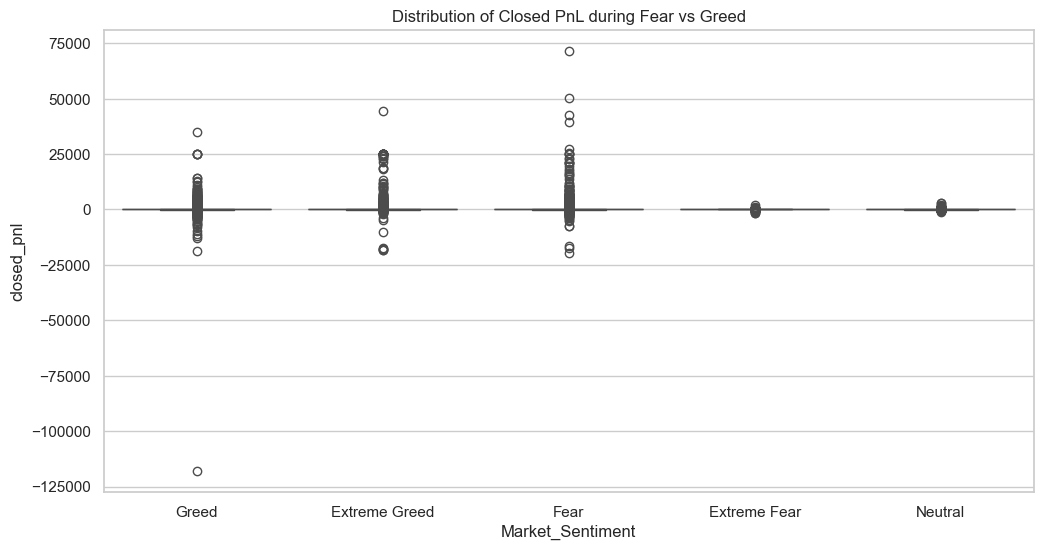

In [9]:
sns.boxplot(x='Market_Sentiment', y='closed_pnl', data=merged_df)
plt.title("Distribution of Closed PnL during Fear vs Greed")
plt.show()

In [10]:
print("Average Closed PnL by Market Sentiment:")
print(merged_df.groupby('Market_Sentiment')['closed_pnl'].mean())

Average Closed PnL by Market Sentiment:
Market_Sentiment
Extreme Fear       1.891632
Extreme Greed    205.816345
Fear             128.287950
Greed             53.988003
Neutral           27.088803
Name: closed_pnl, dtype: float64


In [11]:
merged_df['win'] = merged_df['closed_pnl'] > 0
win_rate = merged_df.groupby('Market_Sentiment')['win'].mean()
print("Win Rate by Sentiment:")
print(win_rate)

Win Rate by Sentiment:
Market_Sentiment
Extreme Fear     0.292777
Extreme Greed    0.553282
Fear             0.381787
Greed            0.435707
Neutral          0.494920
Name: win, dtype: float64


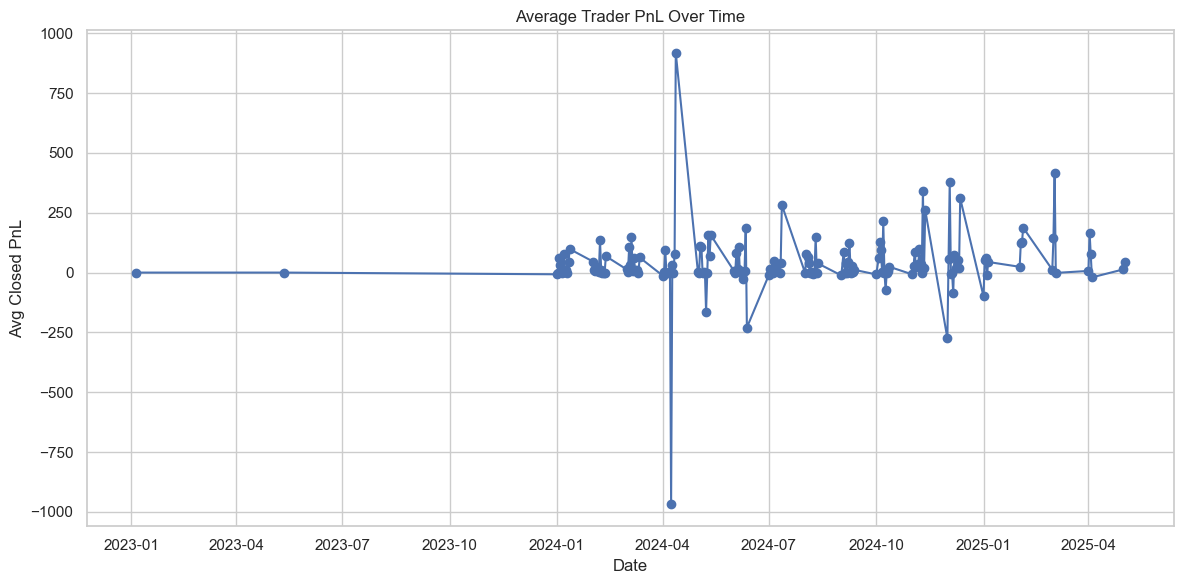

In [12]:
daily_pnl = merged_df.groupby('trade_date')['closed_pnl'].mean()

plt.plot(daily_pnl.index, daily_pnl.values, marker='o')
plt.title("Average Trader PnL Over Time")
plt.xlabel("Date")
plt.ylabel("Avg Closed PnL")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
merged_df['sentiment_encoded'] = le.fit_transform(merged_df['Market_Sentiment'])

In [14]:
merged_df['profitable'] = (merged_df['closed_pnl'] > 0).astype(int)

In [15]:
features = ['execution_price', 'size_usd', 'sentiment_encoded']
X = merged_df[features]
y = merged_df['profitable']

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 84.48%


In [19]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      4087
           1       0.84      0.80      0.82      3086

    accuracy                           0.84      7173
   macro avg       0.84      0.84      0.84      7173
weighted avg       0.84      0.84      0.84      7173



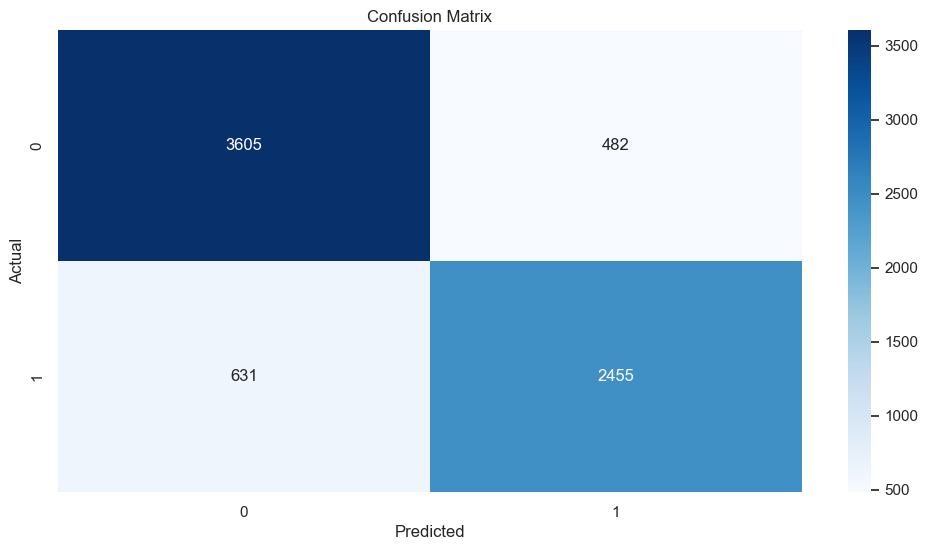

In [20]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

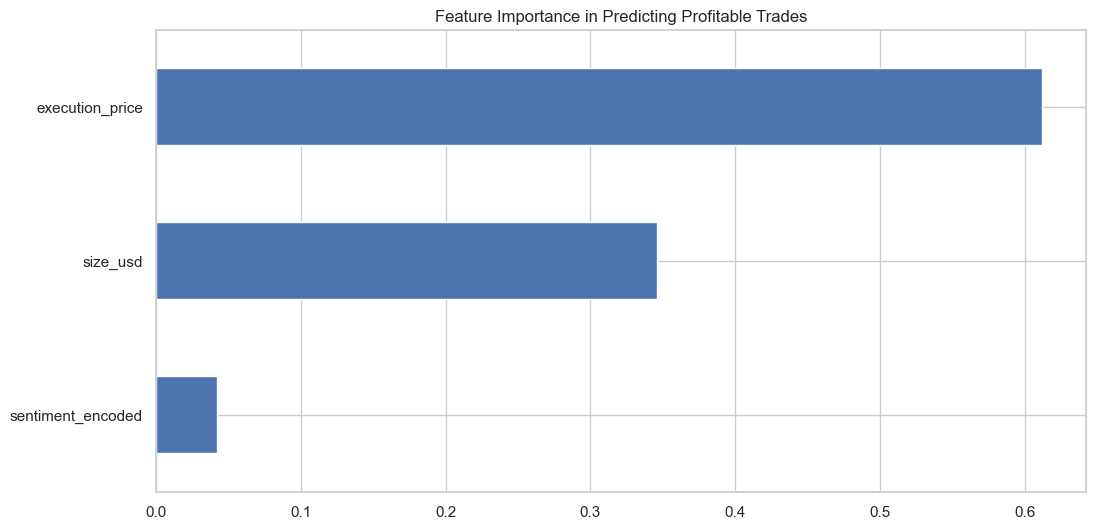

In [21]:
importances = pd.Series(clf.feature_importances_, index=features)
importances.sort_values().plot(kind='barh')
plt.title("Feature Importance in Predicting Profitable Trades")
plt.show()

In [ ]:
strategy_df = merged_df.groupby(['Account', 'Market_Sentiment'])['closed_pnl'].mean().unstack()

In [ ]:
filtered = strategy_df[['Fear', 'Greed']].dropna()
filtered['bias'] = filtered['Greed'] - filtered['Fear']
filtered = filtered.sort_values('bias')

In [24]:
print("Top 5 traders who perform better in 'Fear':")
print(filtered.head())


Top 5 traders who perform better in 'Fear':
Market_Sentiment                                  Fear       Greed        bias
Account                                                                       
0x72c6a4624e1dffa724e6d00d64ceae698af892a0  996.439069    0.000000 -996.439069
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3  388.204726 -572.553463 -960.758190
0x083384f897ee0f19899168e3b1bec365f52a9012  502.539343 -151.066687 -653.606030
0x39cef799f8b69da1995852eea189df24eb5cae3c   15.371584 -235.504317 -250.875900
0x4f93fead39b70a1824f981a54d4e55b278e9f760  137.327338   42.472732  -94.854606


In [25]:
print("Top 5 traders who perform better in 'Greed':")
print(filtered.tail())

Top 5 traders who perform better in 'Greed':
Market_Sentiment                                 Fear       Greed        bias
Account                                                                      
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  97.145610  163.733156   66.587546
0x513b8629fe877bb581bf244e326a047b249c4ff1   0.000000  177.030131  177.030131
0x2c229d22b100a7beb69122eed721cee9b24011dd -47.385796  145.996529  193.382325
0xbaaaf6571ab7d571043ff1e313a9609a10637864  10.633226  252.845216  242.211990
0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0  37.868538  550.950039  513.081501
